In [1]:
import dask as dsk
import seaborn as sn
import plotly.express as pl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import levene,shapiro,chi2_contingency,kruskal

In [2]:
data= pd.read_csv("dataset\MPSA.csv",nrows=1000000)

In [3]:
def analys_exploratoire(df) :
       print("information sur le dataset", df.info())
       print("information sur les doublons :", df.duplicated().value_counts())
       print("information sur le nan :", df.isnull().sum())


le doublon False    1000000
Name: count, dtype: int64

=== Variables numériques ===


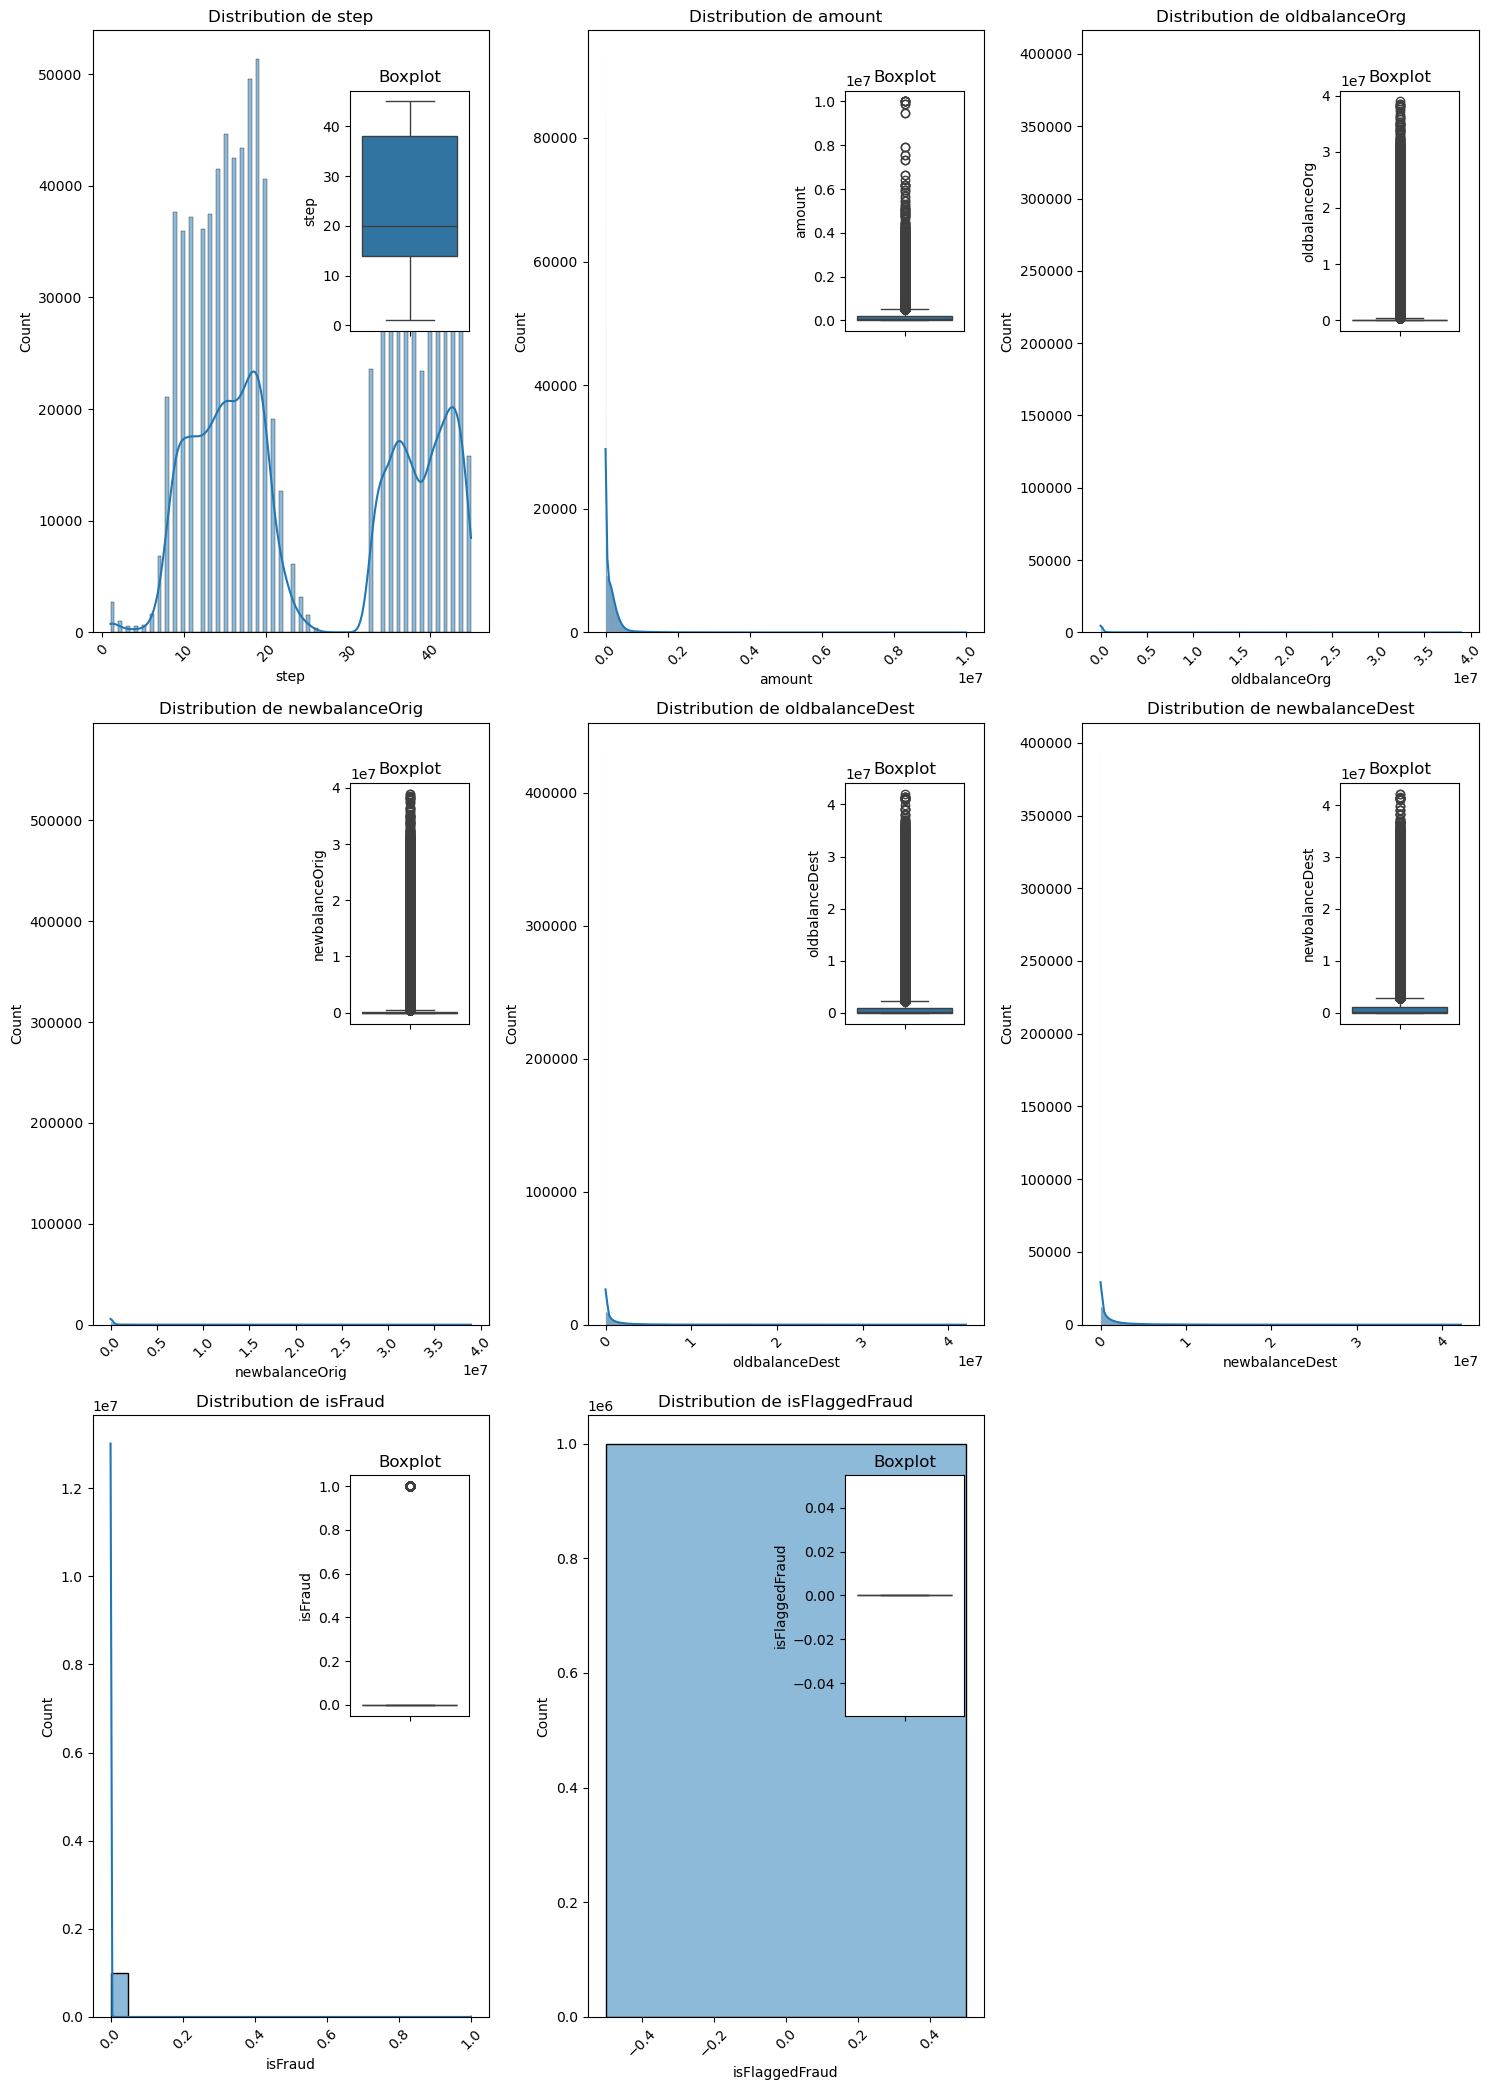


Statistiques descriptives :
                 step        amount  oldbalanceOrg  newbalanceOrig  \
count  1000000.000000  1.000000e+06   1.000000e+06    1.000000e+06   
mean        25.156387  1.602499e+05   8.776703e+05    8.983465e+05   
std         12.652100  2.592584e+05   2.982420e+06    3.019326e+06   
min          1.000000  1.000000e-01   0.000000e+00    0.000000e+00   
25%         14.000000  1.275993e+04   0.000000e+00    0.000000e+00   
50%         20.000000  7.953670e+04   1.595700e+04    0.000000e+00   
75%         38.000000  2.166060e+05   1.397520e+05    1.797911e+05   
max         45.000000  1.000000e+07   3.893942e+07    3.894623e+07   

       oldbalanceDest  newbalanceDest         isFraud  isFlaggedFraud  
count    1.000000e+06    1.000000e+06  1000000.000000       1000000.0  
mean     9.860668e+05    1.125662e+06        0.000535             0.0  
std      2.305423e+06    2.426587e+06        0.023124             0.0  
min      0.000000e+00    0.000000e+00        0.00000

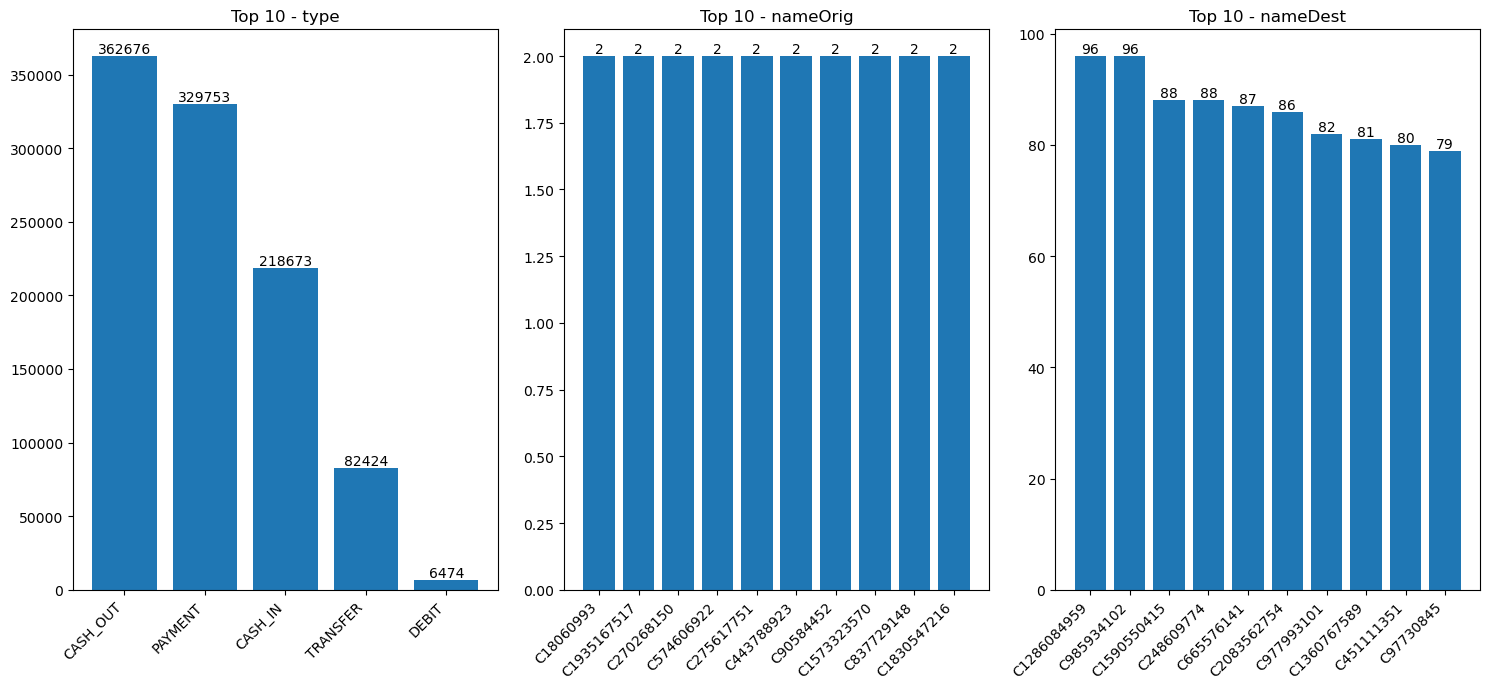


Proportion des catégories :

type:
type
CASH_OUT    36.3%
PAYMENT     33.0%
CASH_IN     21.9%
TRANSFER     8.2%
DEBIT        0.6%
Name: proportion, dtype: object

nameOrig:
nameOrig
C18060993      0.0%
C1935167517    0.0%
C270268150     0.0%
C574606922     0.0%
C275617751     0.0%
C443788923     0.0%
C90584452      0.0%
C1573323570    0.0%
C837729148     0.0%
C1830547216    0.0%
Name: proportion, dtype: object

nameDest:
nameDest
C1286084959    0.0%
C985934102     0.0%
C1590550415    0.0%
C248609774     0.0%
C665576141     0.0%
C2083562754    0.0%
C977993101     0.0%
C1360767589    0.0%
C451111351     0.0%
C97730845      0.0%
Name: proportion, dtype: object


In [4]:
def visualiser_variables_cote_a_cote(df, n_cols=2, figsize=(15, 5)):
    """
    Visualise les variables côte à côte avec diagrammes en barres pour les catégorielles
    
    Parameters:
    -----------
    df : pandas DataFrame
        Le DataFrame à analyser
    n_cols : int
        Nombre de graphiques par ligne
    figsize : tuple
        Taille de base pour chaque groupe de graphiques
    """
    # Séparer les variables par type
    print('le doublon',data.duplicated().value_counts())
    num_cols = df.select_dtypes(include=[np.number]).columns
    cat_cols = df.select_dtypes(exclude=[np.number]).columns
    
    def create_subplot_grid(n_vars, n_cols):
        n_rows = (n_vars + n_cols - 1) // n_cols
        fig_height = figsize[1] * n_rows
        return plt.subplots(n_rows, n_cols, figsize=(figsize[0], fig_height))
    
    # Visualiser les variables numériques
    if len(num_cols) > 0:
        print("\n=== Variables numériques ===")
        fig, axes = create_subplot_grid(len(num_cols), n_cols)
        if len(num_cols) == 1:
            axes = np.array([axes])
        axes = axes.flatten()
        
        for idx, col in enumerate(num_cols):
            if idx < len(axes):
                # Créer deux sous-graphiques côte à côte
                ax1 = axes[idx]
                
                # Histogramme
                plt.ticklabel_format(axis='x', style='plain', scilimits=(0,0))
                sn.histplot(data=df, x=col, kde=True, ax=ax1)
                ax1.set_title(f'Distribution de {col}')
                ax1.tick_params(axis='x', rotation=45)
                
                # Boxplot en insert
                ins = ax1.inset_axes([0.65, 0.5, 0.3, 0.4])
                sn.boxplot(data=df, y=col, ax=ins)
                ins.set_title('Boxplot')
        
        for idx in range(len(num_cols), len(axes)):
            axes[idx].set_visible(False)
            
        plt.tight_layout()
        plt.show()
        
        # Statistiques descriptives
        print("\nStatistiques descriptives :")
        print(df[num_cols].describe())
    
    # Visualiser les variables catégorielles avec diagrammes en barres
    if len(cat_cols) > 0:
        print("\n=== Variables catégorielles ===")
        fig, axes = create_subplot_grid(len(cat_cols), n_cols)
        if len(cat_cols) == 1:
            axes = np.array([axes])
        axes = axes.flatten()
        
        for idx, col in enumerate(cat_cols):
            if idx < len(axes):
                # Calculer les fréquences
                value_counts = df[col].value_counts()
                if len(value_counts) > 10:
                    value_counts = value_counts.head(10)
                
                # Diagramme en barres vertical
                plt.sca(axes[idx])
                bars = plt.bar(range(len(value_counts)), value_counts.values)
                plt.title(f'Top 10 - {col}')
                plt.xticks(range(len(value_counts)), value_counts.index, rotation=45, ha='right')
                
                # Ajouter les valeurs sur les barres
                for bar in bars:
                    height = bar.get_height()
                    plt.text(bar.get_x() + bar.get_width()/2., height,
                            f'{int(height)}', ha='center', va='bottom')
        
        for idx in range(len(cat_cols), len(axes)):
            axes[idx].set_visible(False)
            
        plt.tight_layout()
        plt.show()
        
        # Afficher les proportions
        print("\nProportion des catégories :")
        for col in cat_cols:
            print(f"\n{col}:")
            prop = df[col].value_counts(normalize=True).head(10)
            print(prop.apply(lambda x: f"{x:.1%}"))

# Utilisation de la fonction
visualiser_variables_cote_a_cote(data, n_cols=3, figsize=(15, 7))

In [5]:
analys_exploratoire(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1000000 non-null  int64  
 1   type            1000000 non-null  object 
 2   amount          1000000 non-null  float64
 3   nameOrig        1000000 non-null  object 
 4   oldbalanceOrg   1000000 non-null  float64
 5   newbalanceOrig  1000000 non-null  float64
 6   nameDest        1000000 non-null  object 
 7   oldbalanceDest  1000000 non-null  float64
 8   newbalanceDest  1000000 non-null  float64
 9   isFraud         1000000 non-null  int64  
 10  isFlaggedFraud  1000000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 83.9+ MB
information sur le dataset None
information sur les doublons : False    1000000
Name: count, dtype: int64
information sur le nan : step              0
type              0
amount            0
nameOrig          0
old

In [6]:
data.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [7]:
# afficher le type de transaction recu par les clients
"""dans ce tableau on constate que tous les clients ne preferent pas  le type debit et puis la 
majorite ne preferent non plus le type payement ,le client ayant id C1000124976 a effectué beaucoup de transaction de type depot 6 fois et 8 
fois la transaction retrait"""

'dans ce tableau on constate que tous les clients ne preferent pas  le type debit et puis la \nmajorite ne preferent non plus le type payement ,le client ayant id C1000124976 a effectué beaucoup de transaction de type depot 6 fois et 8 \nfois la transaction retrait'

In [8]:
frame_cont=pd.crosstab(data.type,data.nameDest)

In [9]:
data.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [10]:
frame_cont

nameDest,C1000015936,C1000022185,C1000030947,C1000038153,C1000038201,C1000057469,C1000094209,C1000104864,C1000113023,C1000124976,...,M999921450,M999925457,M999942490,M999942604,M999950506,M99995342,M999981724,M999989895,M999995419,M999996397
type,,,,,,,,,,,,,,,,,,,,,
CASH_IN,4,1,2,3,0,2,1,2,1,6,...,0,0,0,0,0,0,0,0,0,0
CASH_OUT,4,0,1,1,1,0,0,3,0,8,...,0,0,0,0,0,0,0,0,0,0
DEBIT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PAYMENT,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
TRANSFER,1,0,0,0,0,0,0,0,1,4,...,0,0,0,0,0,0,0,0,0,0


In [11]:
frame_type=pd.crosstab(data.isFraud,data.nameDest)

In [12]:
frame_type

nameDest,C1000015936,C1000022185,C1000030947,C1000038153,C1000038201,C1000057469,C1000094209,C1000104864,C1000113023,C1000124976,...,M999921450,M999925457,M999942490,M999942604,M999950506,M99995342,M999981724,M999989895,M999995419,M999996397
isFraud,,,,,,,,,,,,,,,,,,,,,
0,9,1,3,4,1,2,1,5,2,18,...,1,1,1,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
data.groupby('type')['amount'].describe().sort_values(by='mean',ascending=False)

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
TRANSFER,82424.0,637801.433874,593936.353718,2.60,208632.7850,469854.415,888050.600,10000000.00
CASH_OUT,362676.0,183736.075220,148497.339635,0.37,76487.8625,154756.730,259389.035,10000000.00
CASH_IN,218673.0,170457.887828,128647.795601,1.42,70660.5700,144096.260,241449.940,1781905.26
PAYMENT,329753.0,11313.154989,9892.066483,0.10,4154.0000,8802.100,15588.140,115264.68
DEBIT,6474.0,5873.896199,14943.701302,0.87,1645.6475,3320.245,5819.720,408672.22


In [14]:
fraude_cont=pd.crosstab(data.isFraud,data.type)

In [15]:
fraude_cont

type,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
isFraud,,,,,
0,218673,362401,6474,329753,82164
1,0,275,0,0,260


nous constatons que la transaction de type cash_out contient des fraudes y compris celle de transfer ,meme le test  de khi-2 
le confirme

In [16]:

chi2_contingency(fraude_cont)[1]

np.float64(2.1661731434745574e-299)

In [17]:
def relation_variable_numerique(df) :
    display(df.select_dtypes(include="float").corr())
    cat=df[['type','isFraud']]
    for cat in cat :
           for col in df.select_dtypes(include="float") :
            plt.figure()
            plt.title(f"relation entre {col} et {cat}")
            sn.boxplot(df,x=df[cat],y=df[col])
           


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
amount,1.000000,-0.001597,-0.003305,0.216095,0.312749
oldbalanceOrg,-0.001597,1.000000,0.999246,0.091808,0.062393
newbalanceOrig,-0.003305,0.999246,1.000000,0.093564,0.062169
oldbalanceDest,0.216095,0.091808,0.093564,1.000000,0.977992
newbalanceDest,0.312749,0.062393,0.062169,0.977992,1.000000


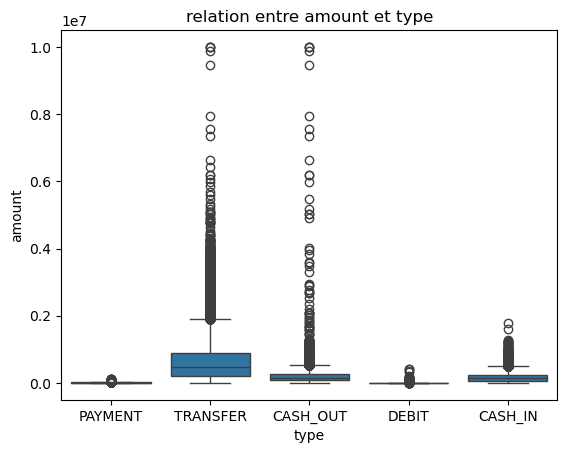

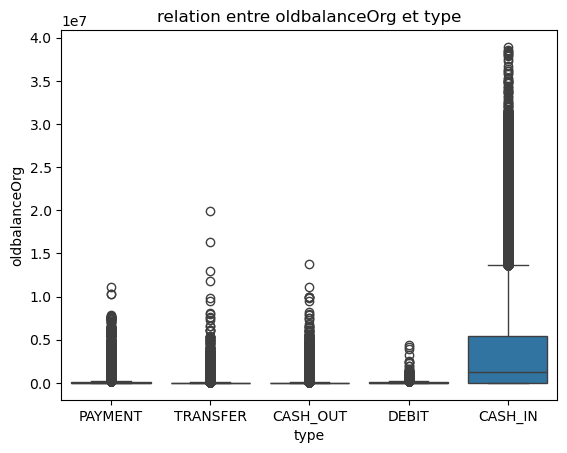

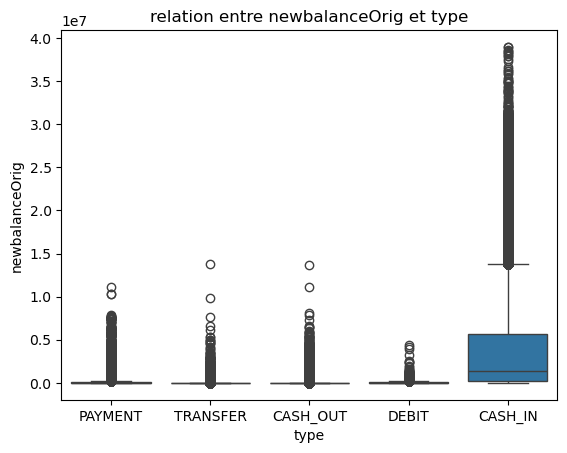

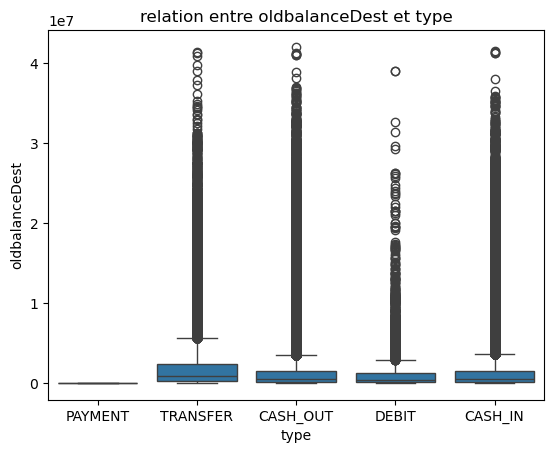

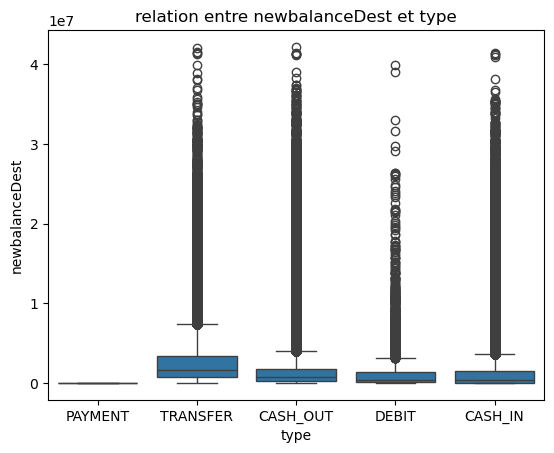

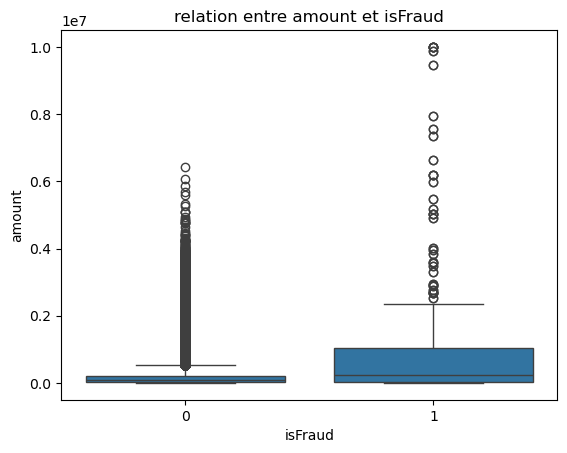

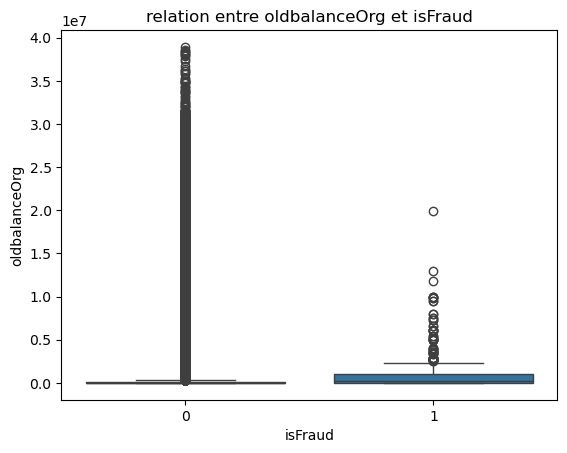

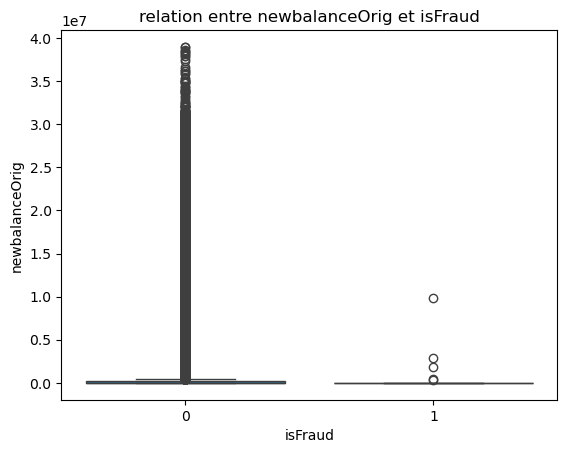

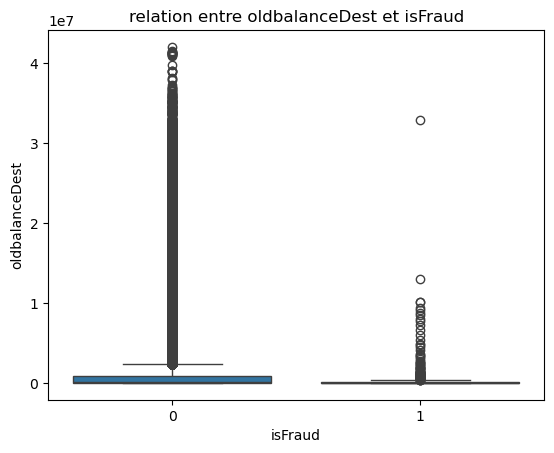

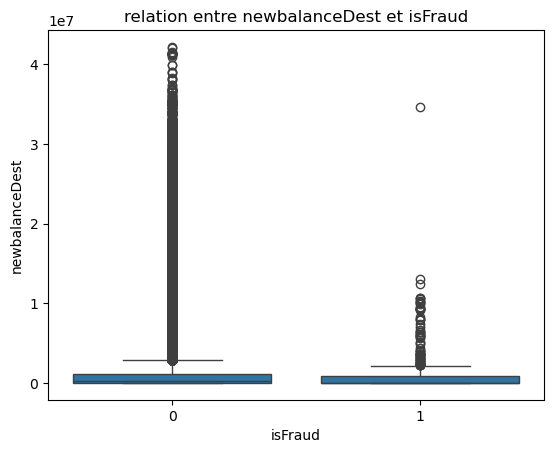

In [18]:
relation_variable_numerique(data)

In [19]:
"""Les transactions TRANSFER et CASH_OUT dominent en volume de montant : ce sont les opérations à haut risque pour la fraude et nécessitent une surveillance plus forte.

PAYMENT et DEBIT représentent des flux faibles, souvent de routine.

CASH_IN joue un rôle d’entrée de liquidité dans le système, avec une distribution intermédiaire."""

'Les transactions TRANSFER et CASH_OUT dominent en volume de montant : ce sont les opérations à haut risque pour la fraude et nécessitent une surveillance plus forte.\n\nPAYMENT et DEBIT représentent des flux faibles, souvent de routine.\n\nCASH_IN joue un rôle d’entrée de liquidité dans le système, avec une distribution intermédiaire.'

Oui, l'analyse des différents visuels nous permet de dresser un profil comportemental et financier très précis des fraudeurs dans ce dataset.

Les fraudeurs ne sont pas identifiés par leur nom, mais par les caractéristiques des transactions qu'ils initient, qui sont statistiquement distinctes des transactions légitimes.

🎭 Caractéristiques du Fraudeur (Basées sur les Transactions)
Le fraudeur agit selon un schéma de "videur de compte" (Account Takeover), dont les caractéristiques sont les suivantes :

1. 🎯 Type de Transaction Ciblée
Action Ciblée : La fraude ne concerne que les types de transactions permettant de retirer l'argent du système.

TRANSFER (Virement vers un compte mule).

CASH_OUT (Retrait physique via un agent).

Exclusion : Les fraudeurs n'utilisent pas les transactions de type CASH_IN, PAYMENT, ou DEBIT.

2. 💰 Montant Maximaliste
Montant (amount) : Les transactions frauduleuses impliquent des montants significativement plus élevés que la grande majorité des transactions légitimes (voir graphique amount vs. isFraud).

Objectif : L'objectif est de maximiser le gain en retirant la plus grande somme possible.

3. 📉 Profil Financier de l'Expéditeur
Les caractéristiques de l'expéditeur compromis sont le signal le plus fort de la fraude :

Solde Initial (oldbalanceOrg) : Le solde initial du compte compromis est généralement faible ou modeste (proche de zéro pour la médiane des fraudes). Cela indique que les fraudeurs ciblent des comptes clients classiques, et non les grandes réserves de liquidités de la plateforme.

Solde Final (newbalanceOrig) : Le solde final est presque toujours nul pour les transactions frauduleuses. Ceci est la preuve directe du scénario de "vidage de compte" : l'attaquant envoie un montant égal au solde initial.

Ceci se traduit par un Ratio de Vidage (amount/oldbalanceOrg) proche de 100%.

4. 🔀 Profil du Destinataire
Solde Initial (oldbalanceDest) : Les comptes destinataires de la fraude ont un oldbalanceDest qui est généralement faible ou modéré. Ils sont moins susceptibles d'être les comptes de trésorerie légitimes du système.

Interprétation : Les fonds sont transférés vers des comptes mules (créés pour recevoir les fonds et les blanchir) ou des agents complices, et non vers les plus grandes réserves de liquidités.
En résumé, le fraudeur se caractérise par une action simple et agressive : il s'introduit dans un petit compte client pour effectuer un TRANSFER ou un CASH_OUT qui vide le compte entièrement et immédiatement.

✅ Profil des Non-FraudeursLes transactions légitimes sont extrêmement variées, mais se distinguent par deux grands groupes de comportement basés sur le solde et le type :
1. 💰 Transactions de Réserve et de Trésorerie (Grand Solde)Ce groupe est essentiel car il représente les transactions avec les montants et les soldes initiaux les plus élevés.Rôle du Solde : Elles impliquent les comptes qui détiennent les plus grands soldes initiaux du système (souvent $> 5$ millions).Elles sont caractérisées par la masse d'outliers (les cercles noirs) qui s'étirent jusqu'à 40 millions et plus sur les graphiques de oldbalanceOrg, newbalanceOrg, oldbalanceDest et newbalanceDest.Types Impliqués : Principalement les CASH_IN (le compte riche dépose ou est approvisionné) et, dans une moindre mesure, les TRANSFER (le compte riche reçoit).Comportement : Ces transactions ont souvent un grand amount, mais ne vident pas complètement le compte (le $\text{RatioVidage}$ est faible, et $\text{oldbalanceOrg}$ est souvent beaucoup plus grand que $\text{amount}$).
2. 📉 Transactions d'Usage Quotidien (Petit Solde)Ce groupe constitue la majorité des transactions du dataset.Rôle du Solde : L'expéditeur et le destinataire ont des soldes initiaux (oldbalanceOrg et oldbalanceDest) très faibles (proches de zéro, représentés par les boîtes fines).Montant (amount) : Le montant de la transaction est très faible (médiane largement inférieure aux transactions frauduleuses).Types Impliqués : Principalement PAYMENT, mais aussi la majorité des transactions CASH_OUT et DEBIT.Comportement : Ces transactions suivent la logique de consommation normale, où l'argent circule entre des comptes clients avec des fonds limités.

# LA DETECTION DES ANOMALIES AVEC Isolation Forest      (Forêt d'Isolation)

In [ ]:
def feature_engineering_anomalie(df) :
    df=df.loc[df.type.isin(['TRANSFER','CASH_OUT'])]
    df=df[["amount","oldbalanceOrg","newbalanceOrig","step"]]
    df["amount"] =np.log(df["amount"])
    # --- 1. Création des Variables de Débit et d'Erreur (Début du 'Feature Engineering') ---
    # 1a. Débit Net de l'Expéditeur (DebitNetExpéditeur)
    # C'est le montant réel qui a quitté le compte.
    df['DebitNetExpéditeur'] = (df['oldbalanceOrg'] - df['newbalanceOrig'])
    # Mesure l'incohérence entre le montant déclaré ('amount') et le débit réel.
    # Un ErreurSolde proche de zéro pour les fraudes de vidage est un signal fort.
    df['ErreurSolde'] = (df['amount'] - df['DebitNetExpéditeur'])
    # --- 2. Création du Signal de Vidage (RatioVidage) ---

    # Variable la plus importante pour le 'videur de compte'.
    # Elle nécessite une gestion de la division par zéro.

    # Crée une colonne temporaire pour gérer le dénominateur
    temp_oldbalance = df['oldbalanceOrg'].copy()

    # Remplace les soldes initiaux de zéro par une petite valeur non-nulle
    # pour éviter l'erreur de division (et maintenir un ratio de 0.0 pour ces cas, si le débit est 0)
    # Note: Ces cas (oldbalanceOrg=0) sont souvent des anomalies/fraudes elles-mêmes.
    temp_oldbalance.replace(0, np.finfo(float).eps, inplace=True) 
    # Calcul du Ratio de Vidage
    df['RatioVidage'] = df['DebitNetExpéditeur'] / temp_oldbalance
    # S'assurer que le ratio est plafonné à 1.0 (on ne peut pas retirer plus que 100% du solde)
    df['RatioVidage'] = np.clip(df['RatioVidage'], 0, 1.0)

   
    return df

In [58]:
df= data.copy()

In [59]:
df_an=feature_engineering_anomalie(df.copy())

In [60]:
from sklearn.ensemble import IsolationForest
# Variables d'entraînement
X = df_an
# --- 2. ENTRAÎNEMENT DU MODÈLE ISOLATION FOREST ---
# Nous entraînons le modèle non supervisé pour détecter les anomalies.
# 'contamination': L'estimation de la proportion d'anomalies (fraudes) dans les données.
# Nous utilisons ici 0.1% (0.001) comme estimation typique pour la fraude, 
# mais vous devrez ajuster cette valeur en fonction du taux réel de fraude dans vos données.
iso_forest = IsolationForest(
    n_estimators=100, 
    contamination=0.0012,
    random_state=42, 
   )

# Entraînement du modèle (il apprend ce qui est 'normal')
iso_forest.fit(X)

# --- 3. PRÉDICTION DES SCORES D'ANOMALIE ---

# Le modèle produit deux types de sortie :

# 3a. Score de Décision (plus la valeur est petite, plus c'est anormal)
# Les scores négatifs indiquent des anomalies (fraudes potentielles).
#df_an['anomaly_score'] = iso_forest.decision_function(X)

# 3b. Prédiction Binaire (-1 pour Anomaly, 1 pour Normal)
df_an['anomaly_prediction'] = iso_forest.predict(X)



In [61]:
df_an.anomaly_prediction.value_counts()

anomaly_prediction
 1    444566
-1       534
Name: count, dtype: int64

In [45]:
c=data.loc[data.type.isin(['TRANSFER','CASH_OUT'])]

In [62]:
c[c["isFraud"]==1]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.00,0.00,1,0
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.00,0.00,1,0
680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.00,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...
998513,45,CASH_OUT,357836.57,C198543509,357836.57,0.0,C824285986,51217.85,409054.43,1,0
999221,45,TRANSFER,155761.29,C280136890,155761.29,0.0,C927108992,0.00,0.00,1,0
999222,45,CASH_OUT,155761.29,C719370249,155761.29,0.0,C2024978323,192775.45,348536.74,1,0
999453,45,TRANSFER,7335355.57,C1102672587,7335355.57,0.0,C735323689,0.00,0.00,1,0


In [47]:
c["isFraud"].value_counts()

isFraud
0    444565
1       535
Name: count, dtype: int64

In [63]:
df_an[df_an['anomaly_prediction']==1]

,amount,oldbalanceOrg,newbalanceOrig,step,DebitNetExpéditeur,ErreurSolde,RatioVidage,anomaly_prediction
2,5.198497,181.0,0.00,1,181.00,-175.801503,1.000000,1
3,5.198497,181.0,0.00,1,181.00,-175.801503,1.000000,1
15,12.342062,15325.0,0.00,1,15325.00,-15312.657938,1.000000,1
19,12.279836,705.0,0.00,1,705.00,-692.720164,1.000000,1
24,12.649751,10835.0,0.00,1,10835.00,-10822.350249,1.000000,1
...,...,...,...,...,...,...,...,...
999979,11.916755,367413.0,217658.17,45,149754.83,-149742.913245,0.407593,1
999984,11.096043,29287.0,0.00,45,29287.00,-29275.903957,1.000000,1
999986,9.744654,11080.0,0.00,45,11080.00,-11070.255346,1.000000,1
999987,11.887929,109238.0,0.00,45,109238.00,-109226.112071,1.000000,1
